In [100]:
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [101]:
class market_position(object):
    def __init__(self, mu, sigma, ell, v=0.01):
        '''Initialize the simulator, v is the spread, we assume it is constant for now.'''

        # constant parameters
        self.mu = mu
        self.sigma = sigma
        self.ell = ell
        self.dt = 1
        self.spread = v
        self.transaction_p = 0.7

        # list to contain historical movements of variables
        self.P_L = [10000]
        self.hist_x = [10]
        self.hist_bid = [9.75]
        self.hist_ask = [10.25]
        self.hist_q = [0]
        self.hist_cash = [10000]
        initial_skew = findMaxSkew(self.mu, self.sigma, self.hist_x[-1], self.ell, self.hist_cash[-1], self.hist_q[-1], self.spread, self.dt)
        self.hist_skew = [initial_skew]
        self.Pbuy = [initial_skew]

    def __repr__(self):
        '''Representation'''
        result = ""
        result += "Final stock price is: " + str(self.hist_x) + "\n"
        result += "Final inventory is: " + str(self.hist_q[-1]) + "\n"
        result += "Final cash account is: " + str(self.hist_cash[-1]) + "\n"
        result += "Final P&L is: " + str(self.P_L[-1])
        return result
    
    def set_skew(self, skew):
        '''Set a new skewness of bid ask spread'''
        self.hist_skew.append(skew)

    def get_accumulated_P_L(self, t):
        '''Show hist P&L'''
        return self.P_L
    
    def transaction_coming(self):
        '''Return True as a transaction has arrived, return False as no transaction coming.'''
        return np.random.binomial(1, self.transaction_p) == 1
    
    def buy_sell(self):
        '''Return True as buy transaction, return False as sell transaction'''
        return np.random.binomial(1, self.Pbuy[-1]) == 1
    
    def new_stock_price(self):
        '''Return stock price change as a geometric brownian motion'''
        return self.hist_x[-1] * math.exp((self.mu - (self.sigma ** 2) / 2) * self.dt + self.sigma * np.random.normal() * math.sqrt(self.dt))
    
    def simulate_one_3tree(self):
        '''Simulate one time foreward. This method simulated stock price in 3 branches tree'''
        # simulate incoming transaction, if there is, adjust inventory and cash account
        if self.Pbuy[-1] < 0:
            pass
        if self.transaction_coming():
            if self.buy_sell():
                self.hist_q.append(self.hist_q[-1] + 1)
                self.hist_cash.append(self.hist_cash[-1] - self.hist_bid[-1])
            else:
                self.hist_q.append(self.hist_q[-1] - 1)
                self.hist_cash.append(self.hist_cash[-1] + self.hist_ask[-1])
        else:
            self.hist_q.append(self.hist_q[-1])
            self.hist_cash.append(self.hist_cash[-1])

        self.hist_x.append(self.new_stock_price())
        
        self.P_L.append(self.hist_q[-1] * self.hist_x[-1] + self.hist_cash[-1])
        
        new_skew = findMaxSkew(self.mu, self.sigma, self.hist_x[-1], self.ell, self.hist_cash[-1], self.hist_q[-1], self.spread, self.dt)
        self.hist_skew.append(new_skew)
        self.Pbuy.append(self.hist_skew[-1])
        self.hist_ask.append(self.hist_x[-1] + self.spread * (3 / 2 - 2 * self.hist_skew[-1]))
        self.hist_bid.append(self.hist_x[-1] + self.spread * (1 / 2 - 2 * self.hist_skew[-1]))
        
    def n_simulate(self, n):
        '''simulate n steps'''
        for i in range(n):
            self.simulate_one_3tree()
            if self.Pbuy[-1] < 0:
                break
            if self.P_L[-1] < -1 * self.ell:
                break


In [102]:
def findMaxSkew(mu,sigma,x,ell,cash,Q,vx,dt):
    # Set all relevant parameters
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p_up = (np.exp(mu*dt)-d)/(u-d)
    p_dn = 1-p_up

    #p_buy = p*s
    #p_sell = p*(1-s)
    #price_buy =

    # Scenario S1 & S4:
    if(cash+u*x*Q<ell or cash+d*x*Q<ell):
        return -1

    else:
        upper1 = (-ell+cash+1.5*vx+x*(u*Q+u-1))/(2*vx) # S2
        upper2 = (-ell+cash+1.5*vx+x*(d*Q+d-1))/(2*vx) # S5
        upper = min(upper1,upper2)

        lower1 = (ell-cash+0.5*vx-x*(u*Q-u+1))/(2*vx) # S3
        lower2 = (ell-cash+0.5*vx-x*(d*Q-d+1))/(2*vx) # S6
        lower = max(lower1,lower2)

        if(upper<lower or upper<0 or lower>1): return -1
        else:
            upper = min(upper,1)
            lower = max(lower,0)

            #  we have to: max -4*vx*(s^2) + (4*V-2*X+2*X*exp(mu*t))*s
            #  s = -b/2a
            s = 0.5+0.25*(np.exp(mu*dt)-1)*x/vx
            if(s<=upper and s>=lower): return s
            elif(lower > s): return lower
            else: return upper

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


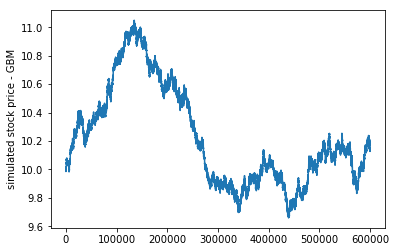

P&L


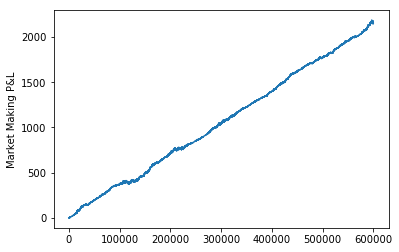

Inventory


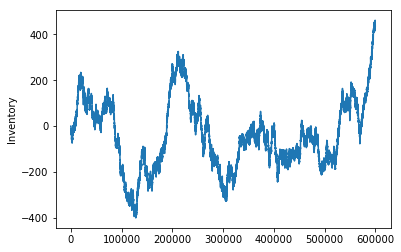

Skew of spread


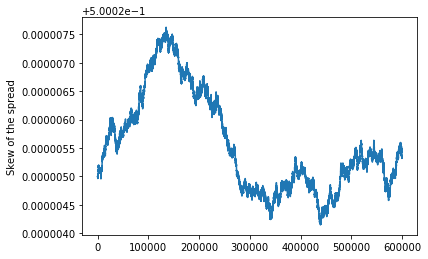

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


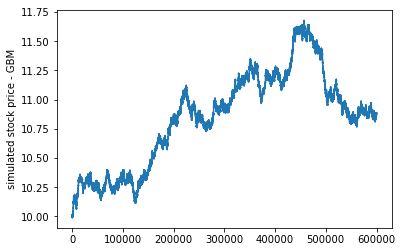

P&L


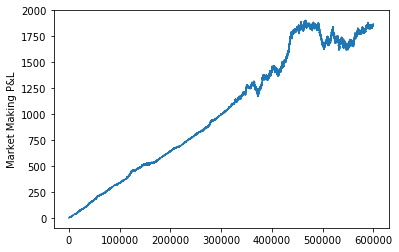

Inventory


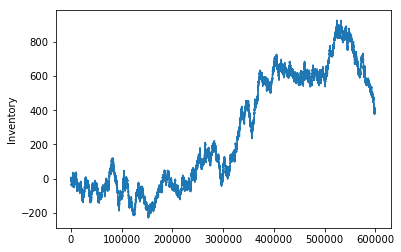

Skew of spread


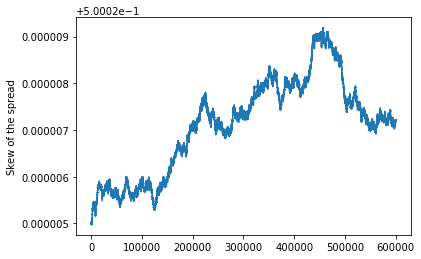

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


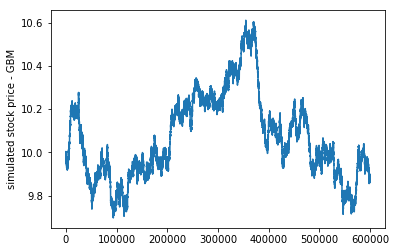

P&L


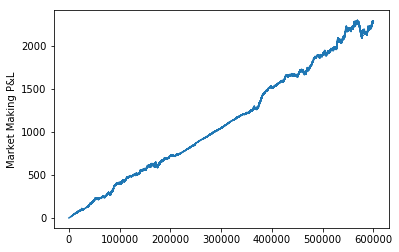

Inventory


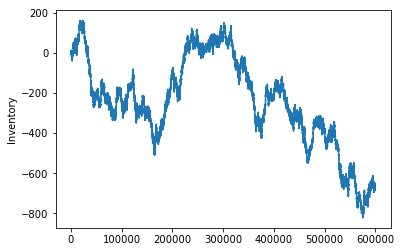

Skew of spread


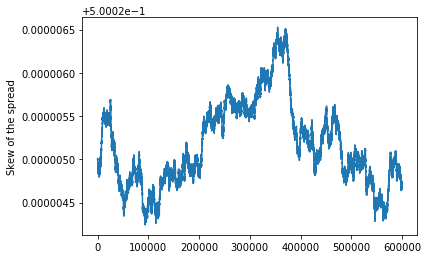

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


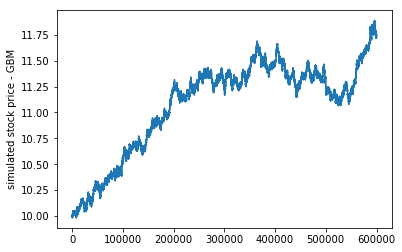

P&L


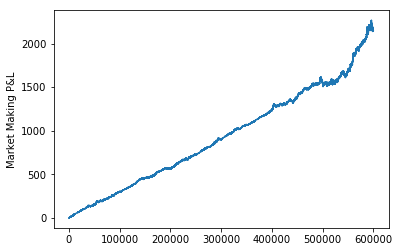

Inventory


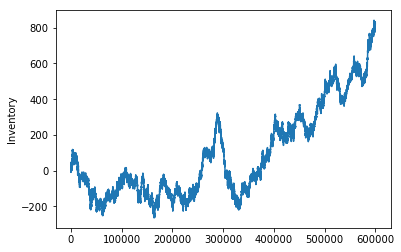

Skew of spread


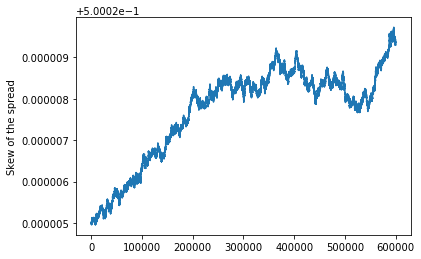

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


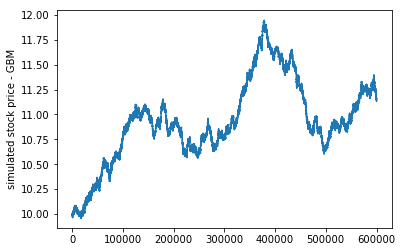

P&L


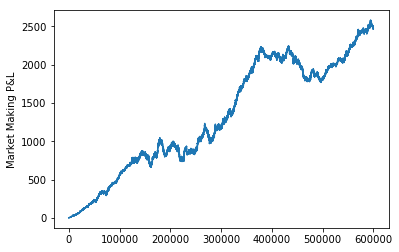

Inventory


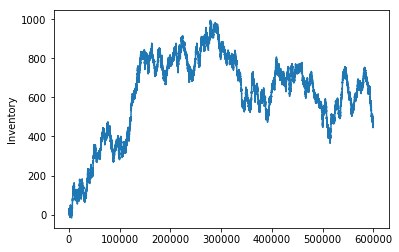

Skew of spread


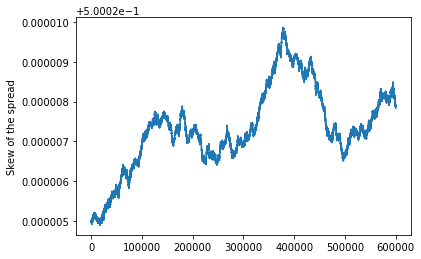

In [103]:
if __name__ == "__main__":
    result = []
    for i in range(5):
        a = market_position(0.0000001, 0.0001, 2000)
        a.n_simulate(600000) # 600000 seconds is about 1 month trading time
        
        df = pd.DataFrame()
        df['skew'] = a.hist_skew
        df['price'] = a.hist_x
        df['bid'] = a.hist_bid
        df['ask'] = a.hist_ask
        df['inventory'] = a.hist_q
        df['cash'] = a.hist_cash
        df['P&L'] = np.array(a.P_L) - 10000
        df['Prob_Buy'] = a.Pbuy
        
        print("Simulation: delta t represented one minites, 120000 minutes is about business time of a year")
        print("Asset Price")
        plt.plot(a.hist_x)
        plt.ylabel('simulated stock price - GBM')
        plt.show()
        
        print("P&L")
        plt.plot(df['P&L'])
        plt.ylabel('Market Making P&L')
        plt.show()
        
        print("Inventory")
        plt.plot(df['inventory'])
        plt.ylabel('Inventory')
        plt.show()
        
        print("Skew of spread")
        plt.plot(df['skew'])
        plt.ylabel('Skew of the spread')
        plt.show()
        
        result.append(a.P_L[-1])
        

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


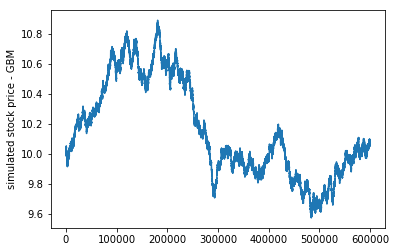

P&L


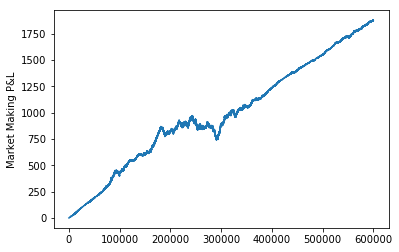

Inventory


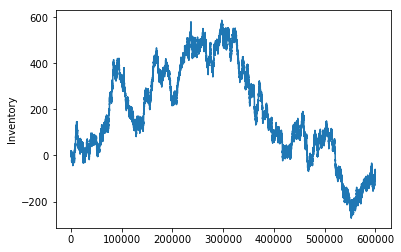

Skew of spread


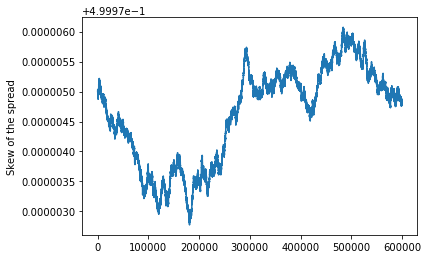

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


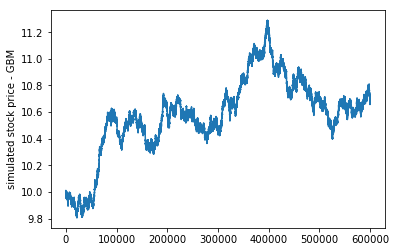

P&L


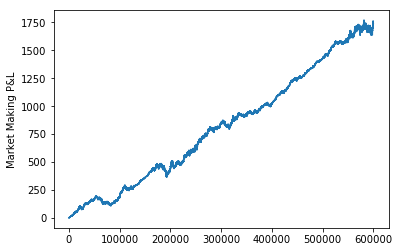

Inventory


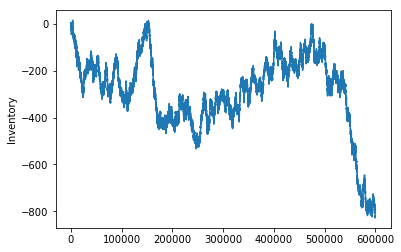

Skew of spread


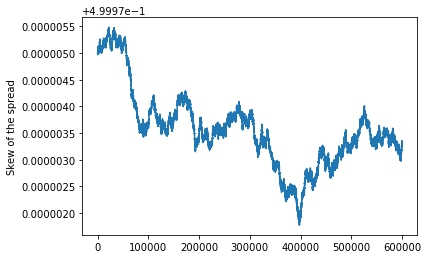

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


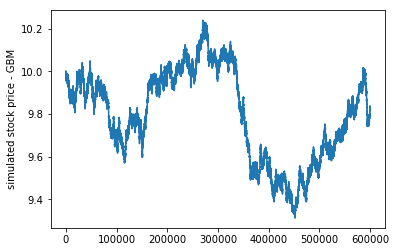

P&L


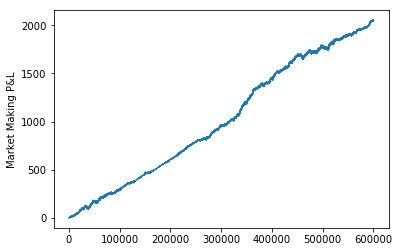

Inventory


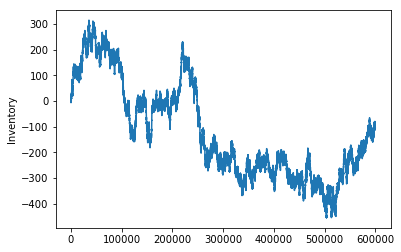

Skew of spread


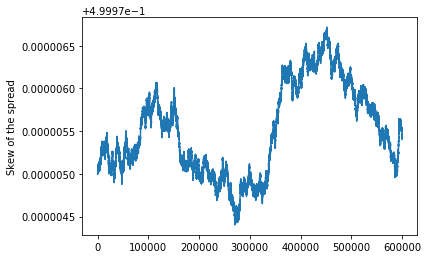

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


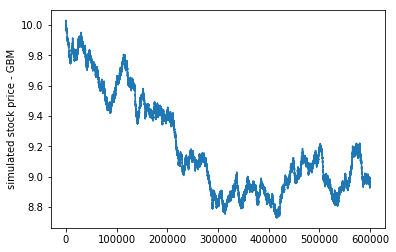

P&L


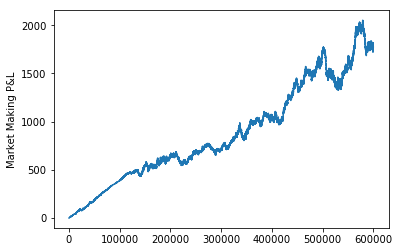

Inventory


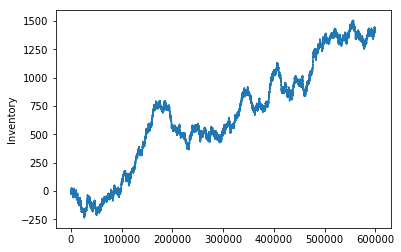

Skew of spread


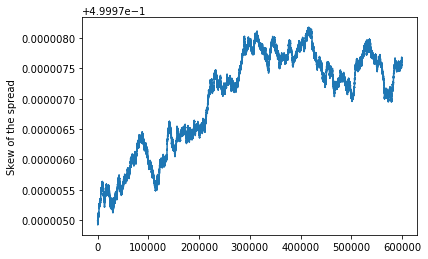

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


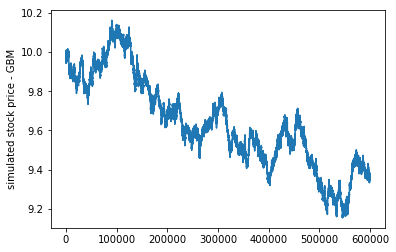

P&L


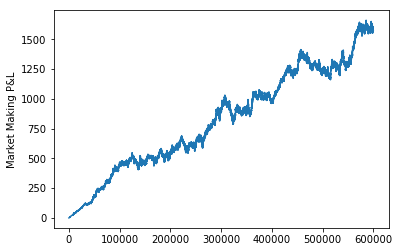

Inventory


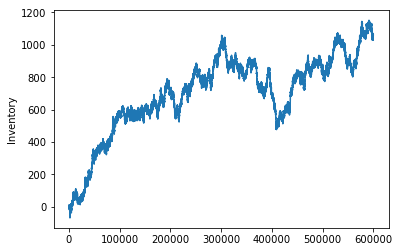

Skew of spread


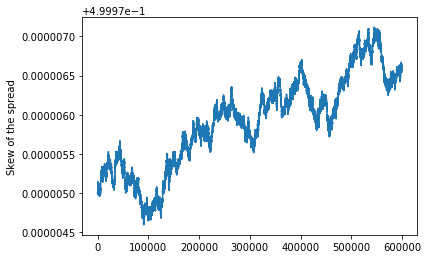

In [104]:
if __name__ == "__main__":
    result = []
    for i in range(5):
        a = market_position(-0.0000001, 0.0001, 2000)
        a.n_simulate(600000) # 600000 seconds is about 1 month trading time
        
        df = pd.DataFrame()
        df['skew'] = a.hist_skew
        df['price'] = a.hist_x
        df['bid'] = a.hist_bid
        df['ask'] = a.hist_ask
        df['inventory'] = a.hist_q
        df['cash'] = a.hist_cash
        df['P&L'] = np.array(a.P_L) - 10000
        df['Prob_Buy'] = a.Pbuy
        
        print("Simulation: delta t represented one minites, 120000 minutes is about business time of a year")
        print("Asset Price")
        plt.plot(a.hist_x)
        plt.ylabel('simulated stock price - GBM')
        plt.show()
        
        print("P&L")
        plt.plot(df['P&L'])
        plt.ylabel('Market Making P&L')
        plt.show()
        
        print("Inventory")
        plt.plot(df['inventory'])
        plt.ylabel('Inventory')
        plt.show()
        
        print("Skew of spread")
        plt.plot(df['skew'])
        plt.ylabel('Skew of the spread')
        plt.show()
        
        result.append(a.P_L[-1])

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


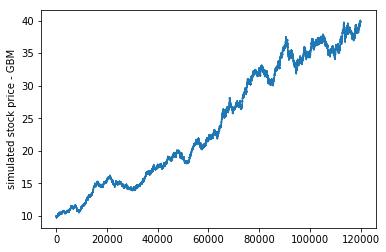

P&L


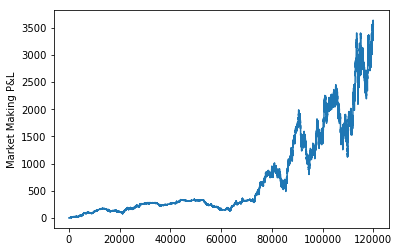

Inventory


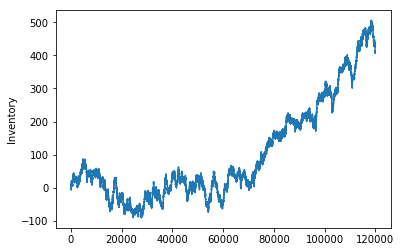

Skew of spread


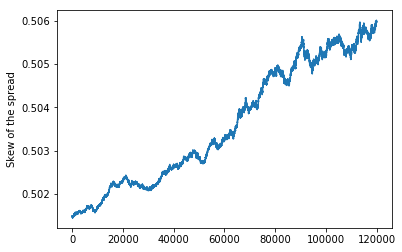

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


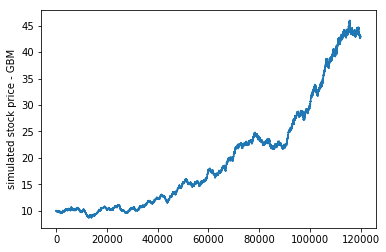

P&L


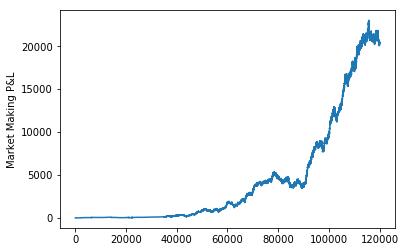

Inventory


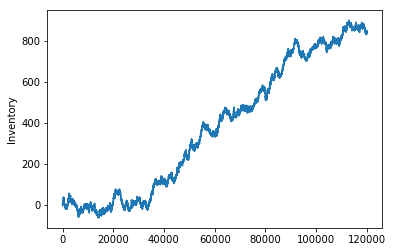

Skew of spread


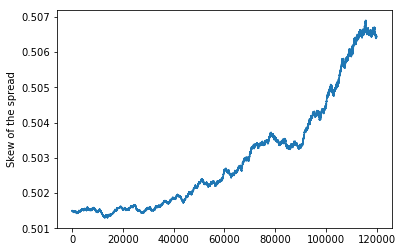

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


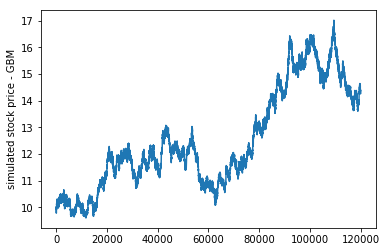

P&L


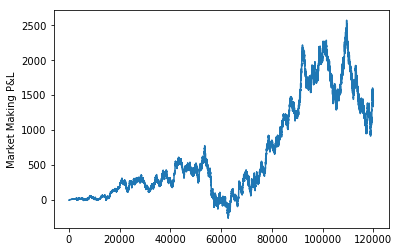

Inventory


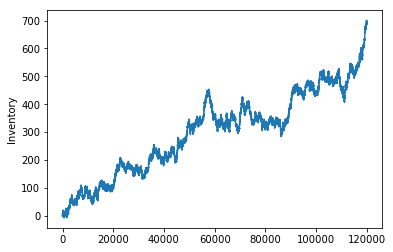

Skew of spread


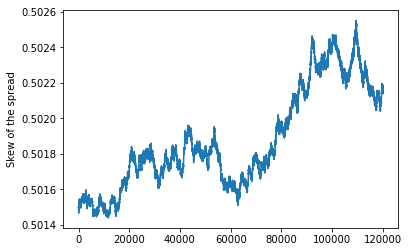

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


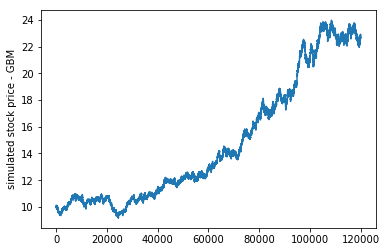

P&L


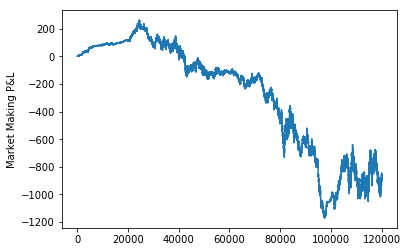

Inventory


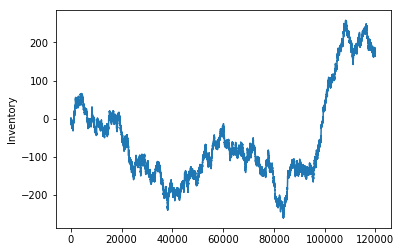

Skew of spread


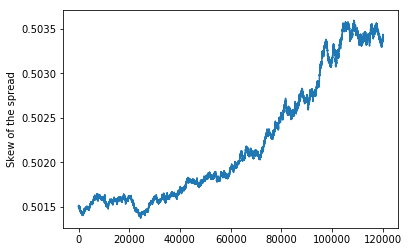

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


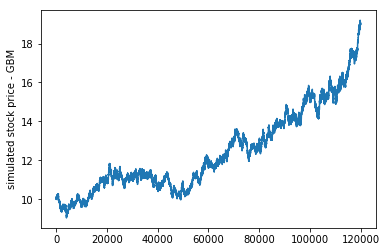

P&L


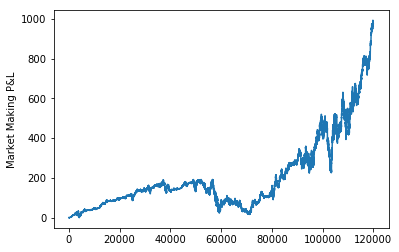

Inventory


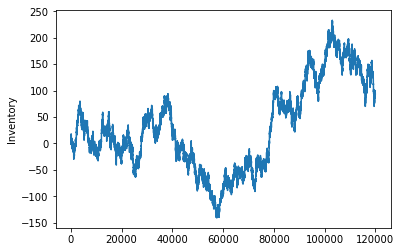

Skew of spread


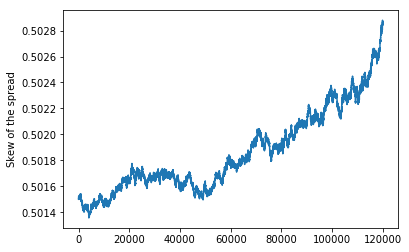

In [105]:
if __name__ == "__main__":
    result = []
    for i in range(5):
        a = market_position(0.000006, 0.001, 2000)
        a.n_simulate(120000) # 120000 minutes is about business time for a year
        
        df = pd.DataFrame()
        df['skew'] = a.hist_skew
        df['price'] = a.hist_x
        df['bid'] = a.hist_bid
        df['ask'] = a.hist_ask
        df['inventory'] = a.hist_q
        df['cash'] = a.hist_cash
        df['P&L'] = np.array(a.P_L) - 10000
        df['Prob_Buy'] = a.Pbuy
        
        print("Simulation: delta t represented one minites, 120000 minutes is about business time of a year")
        print("Asset Price")
        plt.plot(a.hist_x)
        plt.ylabel('simulated stock price - GBM')
        plt.show()
        
        print("P&L")
        plt.plot(df['P&L'])
        plt.ylabel('Market Making P&L')
        plt.show()
        
        print("Inventory")
        plt.plot(df['inventory'])
        plt.ylabel('Inventory')
        plt.show()
        
        print("Skew of spread")
        plt.plot(df['skew'])
        plt.ylabel('Skew of the spread')
        plt.show()
        
        result.append(a.P_L[-1])

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


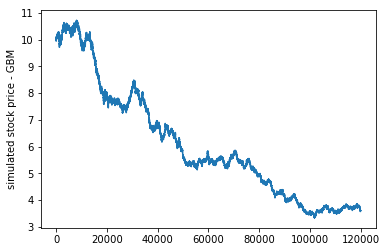

P&L


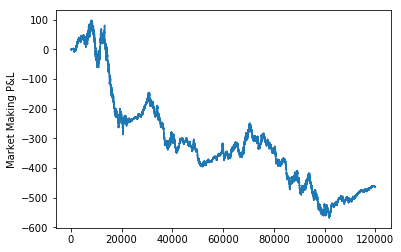

Inventory


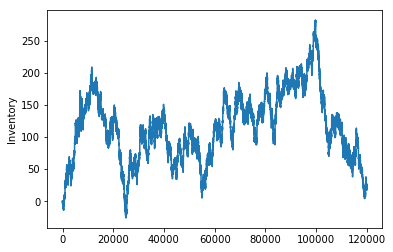

Skew of spread


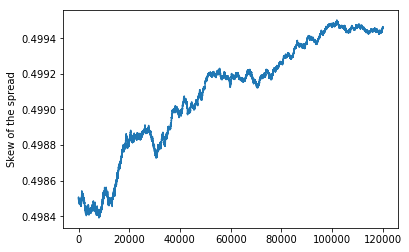

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


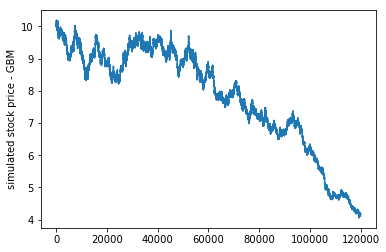

P&L


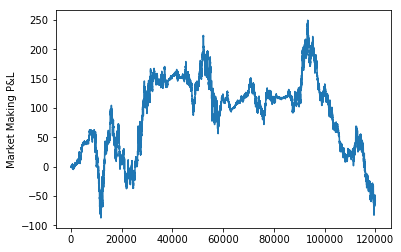

Inventory


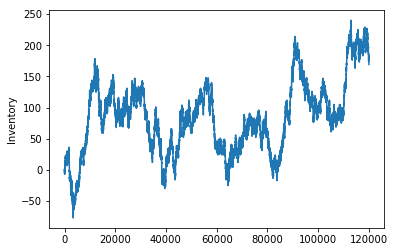

Skew of spread


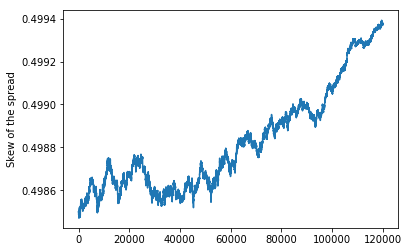

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


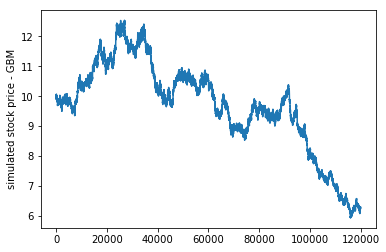

P&L


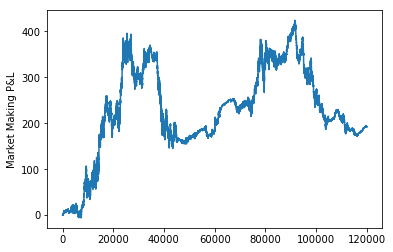

Inventory


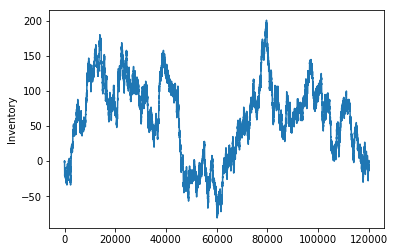

Skew of spread


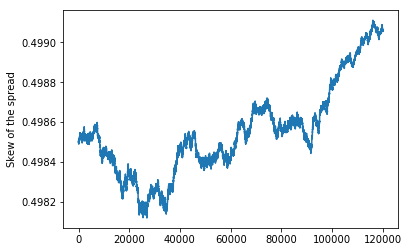

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


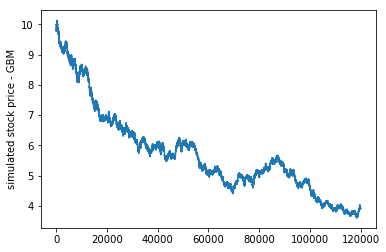

P&L


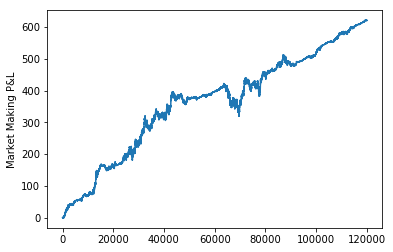

Inventory


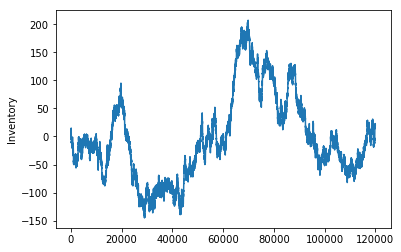

Skew of spread


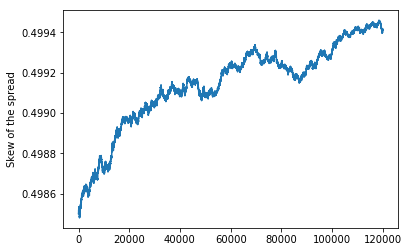

Simulation: delta t represented one minites, 120000 minutes is about business time of a year
Asset Price


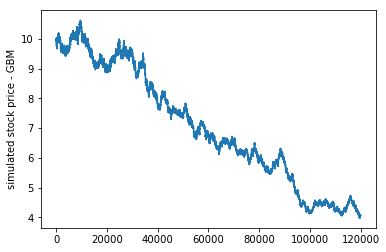

P&L


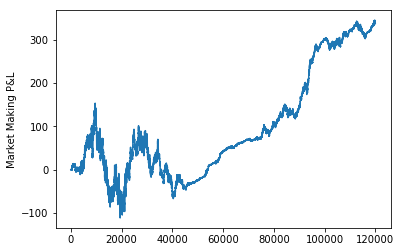

Inventory


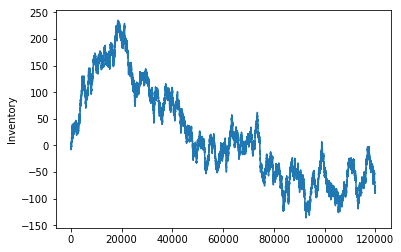

Skew of spread


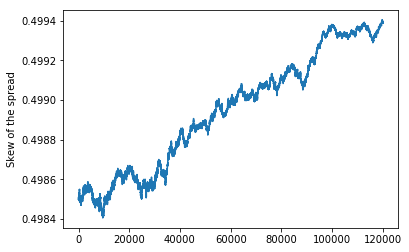

In [106]:
if __name__ == "__main__":
    result = []
    for i in range(5):
        a = market_position(-0.000006, 0.001, 2000)
        a.n_simulate(120000) # 120000 minutes is about business time for a year
        
        df = pd.DataFrame()
        df['skew'] = a.hist_skew
        df['price'] = a.hist_x
        df['bid'] = a.hist_bid
        df['ask'] = a.hist_ask
        df['inventory'] = a.hist_q
        df['cash'] = a.hist_cash
        df['P&L'] = np.array(a.P_L) - 10000
        df['Prob_Buy'] = a.Pbuy
        
        print("Simulation: delta t represented one minites, 120000 minutes is about business time of a year")
        print("Asset Price")
        plt.plot(a.hist_x)
        plt.ylabel('simulated stock price - GBM')
        plt.show()
        
        print("P&L")
        plt.plot(df['P&L'])
        plt.ylabel('Market Making P&L')
        plt.show()
        
        print("Inventory")
        plt.plot(df['inventory'])
        plt.ylabel('Inventory')
        plt.show()
        
        print("Skew of spread")
        plt.plot(df['skew'])
        plt.ylabel('Skew of the spread')
        plt.show()
        
        result.append(a.P_L[-1])
    